In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

#L1 norm
def norm(M):
    return np.sum(M)/M.shape[0]

'''
Main function of the task which returns: 
1. Permutation for clustering matrix
2. Clustered matrix
3. Number of clusters

Function needs to recive:
1. Main matrix where we are going to do the work
2. treshold (number between 0-1) -> Bigger the number more clusters you are going to miss,
but too small will introduce false positive (it will divide good clusters into some smaler parts)
3. First index is telling me where is the start of the diagonal block of interest in current iteration
4. Last index of the block that interests us
5. Cluster borders for ploting red lines (for visual test, how good function performed 
6. Final_permutation -> as I am permutating main matrix I keep track of them so I know which original elements are together in cluster
'''

def spectral_clustering(Cohord, tre ,first_index,last_index, cluster_borders,final_permutation=None):
    # Just for the first iteration permutation is identity
    if final_permutation is None:
        final_permutation = np.array(range(len(Cohord)))

    #Pull out the block of interest for calculating svd
    U, S, Vt= np.linalg.svd(Cohord[first_index:last_index+1, first_index:last_index+1])
    drugi_svojstveni_vektor = U[:,1] #Pull the vecstor with second largest singular value

    # Sorting the indices based on the values of the second svd vector and remembering the permutation for that sort
    perm = zip(drugi_svojstveni_vektor, range(first_index,last_index+1))
    sorted_perm = sorted(perm)
    sorted_indices = [index for value, index in sorted_perm]

    # Count how many negative values are in the second svd vector (to split the cluster)
    number_of_negative_values = sum(1 for value in drugi_svojstveni_vektor if value < 0)

    # Create the full permutation array combining unchanged parts and the sorted block
    full_permutation = np.hstack([list(range(0,first_index)), sorted_indices, list(range(last_index+1,len(Cohord)))]).astype(int)

    # Apply the permutation to the main matrix
    new_Cohord = Cohord[full_permutation, :][:, full_permutation]

    # Calculate norms of the two potential clusters (if we improved “separation”)
    norm1 = norm(new_Cohord[first_index:first_index+number_of_negative_values, first_index:first_index+number_of_negative_values])
    norm2 = norm(new_Cohord[first_index+number_of_negative_values:last_index+1, first_index+number_of_negative_values:last_index+1])
    if min(norm1, norm2) > tre: #both clusters need to be "good enough" to continue splitting
        #Apply permutation to the final permutation tracker
        final_permutation = final_permutation[full_permutation]
        # Append the border where we split
        cluster_borders.append(first_index+number_of_negative_values)
        # Recursive calls for both new clusters
        final_permutation,new_Cohord, N1 = spectral_clustering(new_Cohord, tre, first_index, first_index+number_of_negative_values-1, cluster_borders,final_permutation)
        final_permutation,new_Cohord, N2 = spectral_clustering(new_Cohord, tre, first_index+number_of_negative_values, last_index, cluster_borders,final_permutation)
        return final_permutation, new_Cohord, N1 + N2
    else:
        return final_permutation, Cohord, 1 #if the clusters aren't good enough return original matrix without changes
    

#For ploting our results (Visual test of clustering quality)
def show_heatmap_borders(matrix, title="Matrix Heatmap", cmap='viridis', cluster_borders=None):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap=cmap, aspect='auto')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # Draw cluster borders if provided
    if cluster_borders is not None and len(cluster_borders) > 0:
        for border in cluster_borders:
            # Draw vertical line (separating columns)
            plt.axvline(x=border - 0.5, color='red', linewidth=2, linestyle='--')
            # Draw horizontal line (separating rows)
            plt.axhline(y=border - 0.5, color='red', linewidth=2, linestyle='--')
    
    plt.tight_layout()
    plt.show()


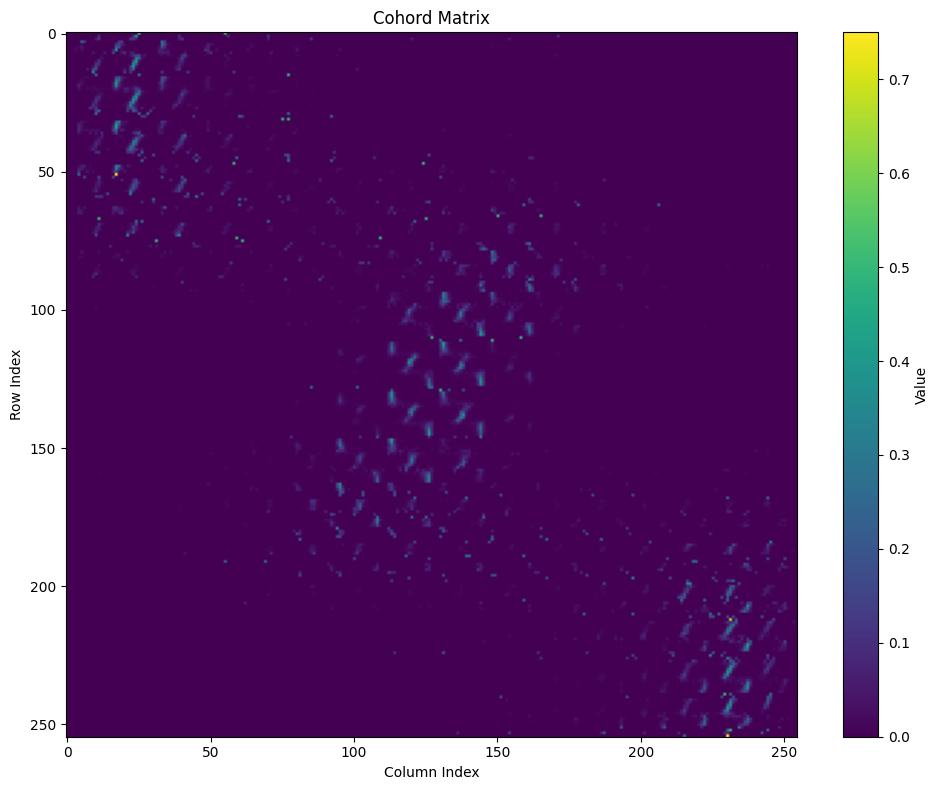

In [2]:
# Before Clustering
mat_data300 = scipy.io.loadmat('Ph300.mat')
Cohord300 = mat_data300['Ph300']
Cohord300 = Cohord300.toarray()
show_heatmap_borders(Cohord300,title="Cohord Matrix", cluster_borders=None)

[47, 67, 109, 133, 169, 215]
Number of clusters found: 7


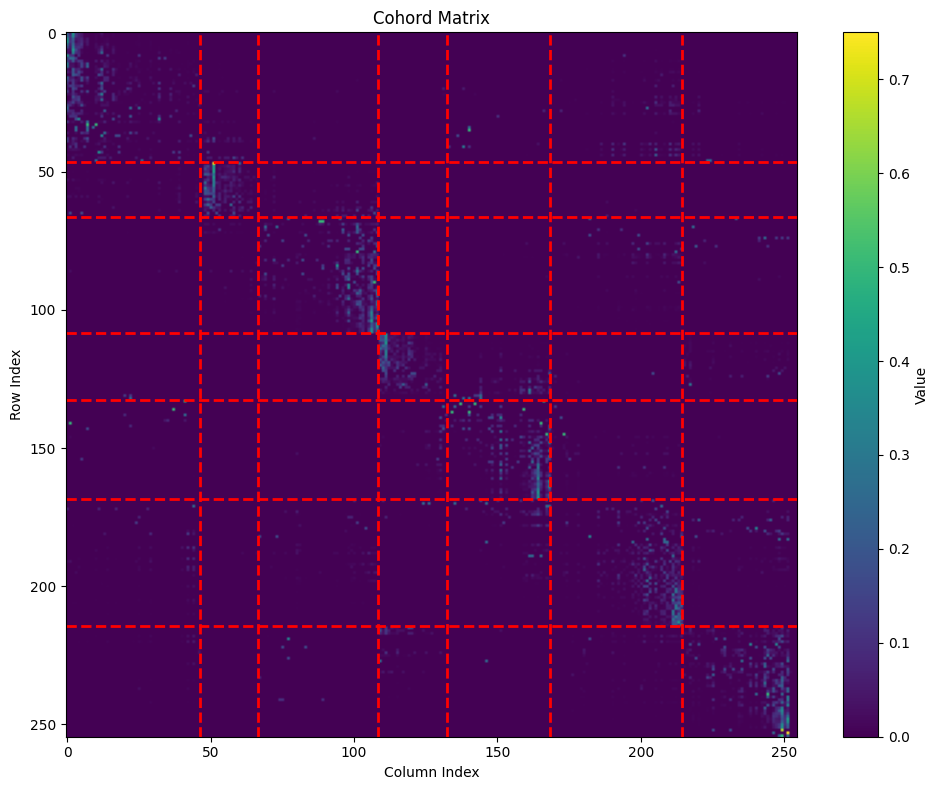

In [3]:
# Load the .mat file
mat_data300 = scipy.io.loadmat('Ph300.mat')
Cohord300 = mat_data300['Ph300']
Cohord300 = Cohord300.toarray()

tre300 = 0.4 #treshold for spectral clustering

cluster_borders300 = []
permutation300, Cohord300, N300 = spectral_clustering(Cohord300, tre300, 0, len(Cohord300)-1, cluster_borders300)
cluster_borders300.sort()
print(cluster_borders300)
print("Number of clusters found:", N300)
#show_heatmap_borders(Cohord,title="Cohord Matrix", cluster_borders=None)
show_heatmap_borders(Cohord300,title="Cohord Matrix", cluster_borders=cluster_borders300)



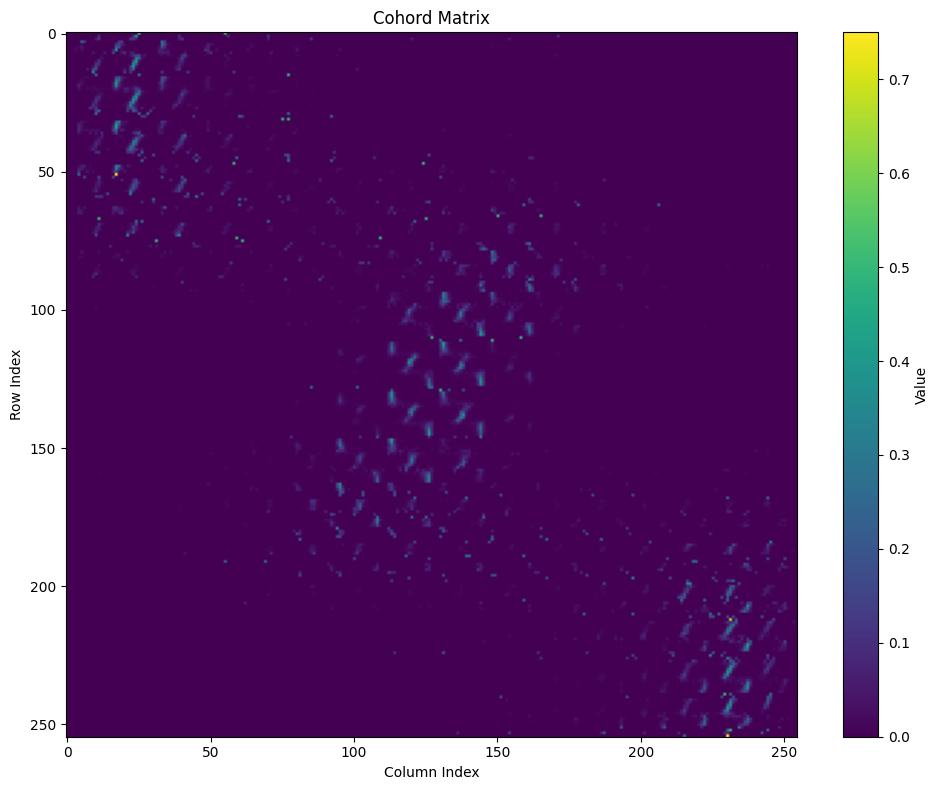

In [4]:
# Before Clustering
mat_data500 = scipy.io.loadmat('Ph300.mat')
Cohord500 = mat_data500['Ph300']
Cohord500 = Cohord500.toarray()
show_heatmap_borders(Cohord500,title="Cohord Matrix", cluster_borders=None)

[71, 116, 159, 196, 247]
Number of clusters found: 6


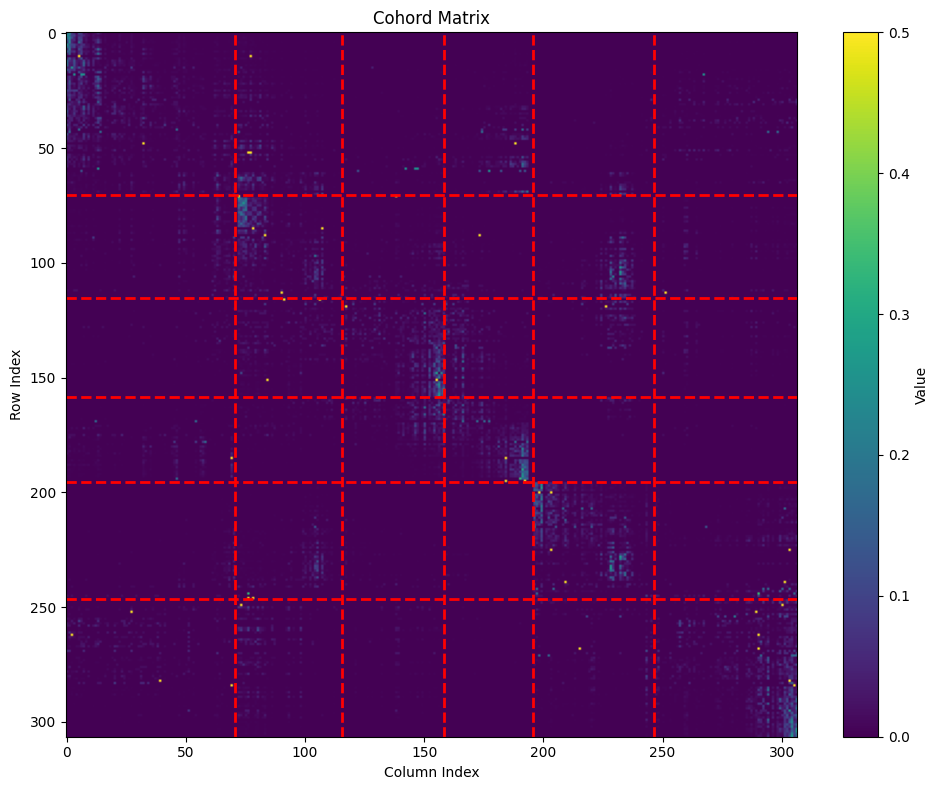

In [5]:
# Load the .mat file
mat_data500 = scipy.io.loadmat('Ph500.mat')
Cohord500 = mat_data500['Ph500']
Cohord500 = Cohord500.toarray()

tre500 = 0.4

cluster_borders500 = []
Permutation500, Cohord500, N500 = spectral_clustering(Cohord500, tre500, 0, len(Cohord500)-1, cluster_borders500)
cluster_borders500.sort()
print(cluster_borders500)
print("Number of clusters found:", N500)
show_heatmap_borders(Cohord500,title="Cohord Matrix", cluster_borders=cluster_borders500)

In [ ]:
'''Function where you pass original_state_name and you get transition vector that has interpretation:
"If you are in state original_state_name Probs[i-1] are chances that in the next step you end up in i-th cluster'''
def transitions(original_state_name,Permutation,Cluster_borders,Cohord):
    now_name = np.argmax(Permutation == original_state_name) #translate original name to the name in permuted matrix 
    Cluster_borders.append(len(Permutation)) #to make the loop easier
    Probs = []
    j=0
    for i in Cluster_borders:
        P = 0
        while j<i:
            P += Cohord[now_name][j]
            j+=1
        Probs.append(P)
    
    return(Probs)


In [7]:
#Test of transitions function (in this example 0 is interestig because he is in th "middle" of two clusters)
transitions(0,Permutation500.copy(),cluster_borders500.copy(),Cohord500.copy())

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.5),
 np.float64(0.5)]

In [8]:
# Testing different tresholds
Tresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
Results1 = []
Results2 = []
for tresh in Tresholds:
    cluster_borders_temp = []
    Permutation_temp, Cohord_temp, N_temp = spectral_clustering(Cohord500, tresh, 0, len(Cohord500)-1, cluster_borders_temp)
    Results1.append(N_temp)
    Permutation_temp, Cohord_temp, N_temp = spectral_clustering(Cohord300, tresh, 0, len(Cohord300)-1, cluster_borders_temp)
    Results2.append(N_temp)




/var/folders/qb/1gz7kjgd1nncs_s1n4yd3st00000gn/T/ipykernel_4833/2254820748.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(M)/M.shape[0]


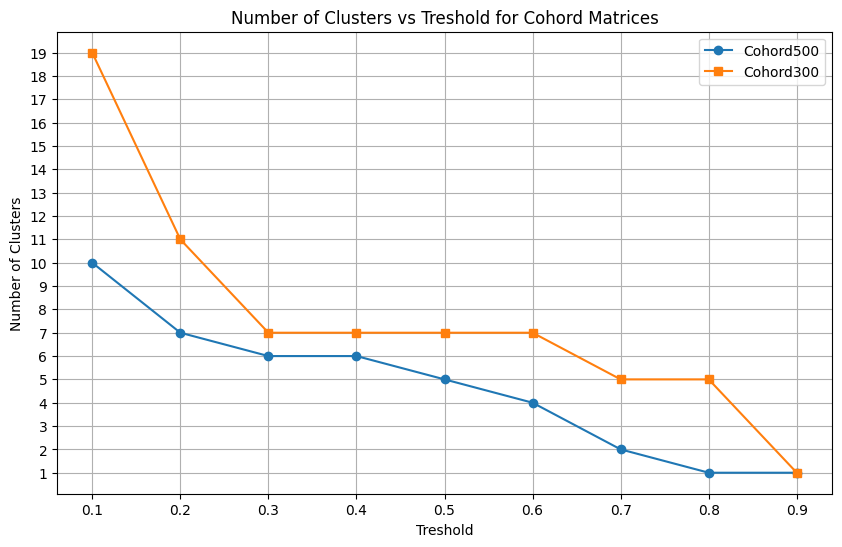

In [9]:
#Ploting the results
plt.figure(figsize=(10, 6))
plt.plot(Tresholds, Results1, marker='o', label='Cohord500')
plt.plot(Tresholds, Results2, marker='s', label='Cohord300')
plt.xticks(Tresholds)
plt.yticks(range(1, max(max(Results1), max(Results2)) + 1))
plt.xlabel('Treshold')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs Treshold for Cohord Matrices')
plt.legend()
plt.grid()
plt.show()